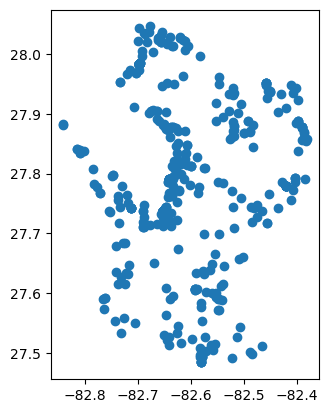

     speciesID       group            family             genus  \
87          57  Amphibians           Hylidae        Osteopilus   
88        1261    Reptiles          Emydidae         Trachemys   
89         110    Mollusks         Mytilidae             Perna   
92         110    Mollusks         Mytilidae             Perna   
93         477      Fishes         Cichlidae      Sarotherodon   
95         110    Mollusks         Mytilidae             Perna   
110         57  Amphibians           Hylidae        Osteopilus   
111        477      Fishes         Cichlidae      Sarotherodon   
112        477      Fishes         Cichlidae      Sarotherodon   
113        463      Fishes         Cichlidae       Oreochromis   
90         110    Mollusks         Mytilidae             Perna   
103       2788      Fishes         Cichlidae       Oreochromis   
123        297      Plants      Salviniaceae          Salvinia   
124        297      Plants      Salviniaceae          Salvinia   
105       

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

geo_data = gpd.read_file(r"C:\Users\AubreyLitzinger\Drummond Carpenter, PLLC\Drummond Carpenter, PLLC Team Site - HackTheBay_2025\Invasives\invasive_species.geojson")
shapefile = gpd.read_file(r"C:\Users\AubreyLitzinger\Drummond Carpenter, PLLC\Drummond Carpenter, PLLC Team Site - HackTheBay_2025\AOI\tb_aoi_1mi_4326.shp")
geo_data = gpd.clip(geo_data, shapefile)

geo_data.plot()
plt.show()

print(geo_data.head(50))

print(geo_data.columns)

geo_data.crs

In [208]:
geo_data.crs
raster.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [210]:
print(geo_data[['speciesID', 'commonName']].value_counts())


speciesID  commonName           
57         Cuban Treefrog           63
1130       common water-hyacinth    51
110        green mussel             44
2942       whorled hydrilla         36
227        alligatorweed            34
                                    ..
1262       Yellow-bellied Slider     1
2266       Goldline Snakehead        1
2995       pepperwort                1
3125       buffalo spinach           1
2997       papyrus                   1
Name: count, Length: 61, dtype: int64


In [131]:
# import geopandas as gpd
# import h3
# import pandas as pd
# from shapely.geometry import Point

# #each location is part of a HEX ID 
# def assign_hex(row, resolution):
#     lat, lon = row.geometry.y, row.geometry.x
#     return h3.latlng_to_cell(lat, lon, resolution)

# resolution = 8  
# geo_data['hex_id'] = geo_data.apply(assign_hex, resolution=resolution, axis=1)

# #the number of species in each hex
# hex_summary = geo_data.groupby('hex_id').size().reset_index(name='count')

# #checking to see if there are multiple species counted in one hex. 

# things = hex_summary['hex_id'].head()  

# # Filter geo_data for these hex IDs
# filtered_data = geo_data[geo_data['hex_id'].isin(things)]

# # Group species by hex ID
# for hex_id, group in filtered_data.groupby('hex_id'):
#     print(f"Hex ID: {hex_id}")
#     print(group['commonName']) 
#     print()

# from shapely.geometry import Polygon

# # had to do this because h3 doesn't have a function to get the boundary
# def hex_boundary(hex_id):
#     boundary = h3.cell_to_boundary(hex_id)
#     # Convert (lat, lon) to (lon, lat) for Shapely
#     boundary = [(lon, lat) for lat, lon in boundary]
#     return Polygon(boundary)

# hex_summary['geometry'] = hex_summary['hex_id'].apply(hex_boundary)
# hex_gdf = gpd.GeoDataFrame(hex_summary, geometry='geometry')


In [3]:
import numpy as np
from h3 import latlng_to_cell, cell_to_boundary
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import geopandas as gpd

raster = rasterio.open(r"C:\Users\AubreyLitzinger\Drummond Carpenter, PLLC\Drummond Carpenter, PLLC Team Site - HackTheBay_2025\TBEP_HackTheBay\Data\LandscapeModel_FLFWC\flam_aoi_4326.tif")

# Get raster bounds and resolution
bounds = raster.bounds
resolution = 7  # Adjust H3 resolution as needed

# Generate grid of lat/lon points within raster bounds
lats = np.arange(bounds[1], bounds[3], raster.res[1])
lons = np.arange(bounds[0], bounds[2], raster.res[0])

# Assign hex IDs to raster points
hex_ids_raster = {latlng_to_cell(lat, lon, resolution) for lat in lats for lon in lons}

# Convert H3 hex IDs to Polygon geometries
hexes_geom = [Polygon([(lon, lat) for lat, lon in cell_to_boundary(hex_id)]) for hex_id in hex_ids_raster]
hex_gdf = gpd.GeoDataFrame({'hex_id': list(hex_ids_raster)}, geometry=hexes_geom)
hex_gdf.set_crs("EPSG:4326", inplace=True)

# Clip hexagons to raster extent using rasterio.mask
def clip_hex_to_raster(hex_geom, raster):
    try:
        # Mask raster with hex geometry
        hex_geojson = [mapping(hex_geom)]
        out_image, out_transform = mask(raster, hex_geojson, crop=True, nodata=0)
        
        # Return hex geometry (it remains the same since no raster bounds are used here)
        return hex_geom if out_image.any() else Polygon()
    except ValueError:
        # Return empty geometry if no overlap
        return Polygon()

hex_gdf['geometry'] = hex_gdf['geometry'].apply(lambda geom: clip_hex_to_raster(geom, raster))

# Drop empty geometries
hex_gdf = hex_gdf[~hex_gdf.geometry.is_empty]


In [4]:
def calculate_avg_raster_value(hex_geom, raster):
    try:
        # Mask raster with hex geometry
        hex_geojson = [mapping(hex_geom)]
        out_image, _ = mask(raster, hex_geojson, crop=True, nodata=0)
        
        # Calculate the mean, ignoring no-data values
        return out_image[out_image > 0].mean()
    except ValueError:
        # Return NaN if no overlap or invalid geometry
        return np.nan
    
hex_gdf['avg_raster_value'] = hex_gdf['geometry'].apply(lambda geom: calculate_avg_raster_value(geom, raster))


In [5]:
hex_gdf.head()
#print(hex_gdf[['hex_id', 'avg_raster_value']])


hex_id                                           geometry  \
0  87441a81dffffff  POLYGON ((-82.64722 27.88373, -82.63788 27.892...   
1  87441a809ffffff  POLYGON ((-82.70237 27.90931, -82.69302 27.918...   
2  87441a813ffffff  POLYGON ((-82.59213 27.85814, -82.5828 27.8671...   
4  87441a803ffffff  POLYGON ((-82.65301 27.86231, -82.64367 27.871...   
5  87441a908ffffff  POLYGON ((-82.72636 27.74362, -82.71703 27.752...   

   avg_raster_value  
0          5.794177  
1          2.797668  
2          3.673983  
4          2.716321  
5          1.241992

In [154]:
# from h3 import latlng_to_cell

# resolution = 7  # Match raster hex resolution
# geo_data['hex_id'] = geo_data.geometry.apply(lambda geom: latlng_to_cell(geom.y, geom.x, resolution))
# species_count = geo_data.groupby('hex_id').size().reset_index(name='species_count')

# genus_count = geo_data.groupby('hex_id')['genus'].nunique().reset_index(name='genus_count')
# hex_gdf = hex_gdf.merge(genus_count, on='hex_id', how='left')
# hex_gdf['genus_count'] = hex_gdf['genus_count'].fillna(0)  # Fill missing values with 0


# hex_gdf = hex_gdf.merge(species_count, on='hex_id', how='left')
# hex_gdf['species_count'] = hex_gdf['species_count'].fillna(0)


In [6]:
from h3 import latlng_to_cell

resolution = 7  # Match raster hex resolution

geo_data['hex_id'] = geo_data.geometry.apply(lambda geom: latlng_to_cell(geom.y, geom.x, resolution))

# Aggregate species and genus counts by hex_id
aggregated_counts = geo_data.groupby('hex_id').agg(
    species_count=('hex_id', 'size'),
    genus_count=('genus', 'nunique')
).reset_index()

# Merge aggregated counts with hex_gdf
hex_gdf = hex_gdf.merge(aggregated_counts, on='hex_id', how='left')

# Fill missing values with 0
hex_gdf[['species_count', 'genus_count']] = hex_gdf[['species_count', 'genus_count']].fillna(0)

In [7]:
# Rank the species and genus counts
hex_gdf['species_count_rk'] = hex_gdf['species_count'].rank(method='min', ascending=False).astype(int)
hex_gdf['genus_count_rk'] = hex_gdf['genus_count'].rank(method='min', ascending=False).astype(int)
hex_gdf['habitat_rk'] = hex_gdf['avg_raster_value'].rank(method='min', ascending=False).astype(int)

# Add a column for the average rank
hex_gdf['average_rank_inv'] = hex_gdf[['species_count_rk', 'genus_count_rk']].mean(axis=1)
hex_gdf['average_rank_all'] = hex_gdf[['average_rank_inv', 'habitat_rk']].mean(axis=1)
hex_gdf['priority_rk'] = hex_gdf['average_rank_all'].rank(method='min', ascending=True).astype(int)



In [8]:
with pd.option_context('display.max_rows', None):
    print(hex_gdf)
    #print(hex_gdf.sort_values(by='species_count', ascending=True))

NameError: name 'pd' is not defined

In [9]:
hex_gdf.to_file(r"C:\Users\AubreyLitzinger\Drummond Carpenter, PLLC\Drummond Carpenter, PLLC Team Site - HackTheBay_2025\TBEP_HackTheBay\Data\AOI\hexagons.geojson", driver="GeoJSON")

# PLOTS

## Non-RK

In [14]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['#4B0092', 'white', '#1AFF1A'], 
    vmin=hex_gdf['avg_raster_value'].min(),
    vmax=hex_gdf['avg_raster_value'].max(),
    caption='Number of Species'
)


m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['avg_raster_value']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

In [174]:
# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'red'], 
    vmin=hex_gdf['genus_count'].min(),
    vmax=hex_gdf['genus_count'].max(),
    caption='Number of Species'
)


m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['genus_count']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

In [217]:
# Create a linear colormap using the value we are plotting. 
# colormap = cm.LinearColormap(
#     colors=['green', 'yellow', 'red'], 
#     vmin=hex_gdf['species_count'].min(),
#     vmax=hex_gdf['species_count'].max(),
#     caption='Number of Species'
# )

colormap = cm.StepColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    index=[0, 1, 50, 500, hex_gdf['species_count'].max()],
    caption='Number of Species'
)

m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['species_count']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

## RK

In [225]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'red'], 
    vmin=hex_gdf['species_count_rk'].min(),
    vmax=hex_gdf['species_count_rk'].max(),
    caption='Number of Species'
)


m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['species_count_rk']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

In [226]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'red'], 
    vmin=hex_gdf['genus_count_rk'].min(),
    vmax=hex_gdf['genus_count_rk'].max(),
    caption='Number of Species'
)


m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['genus_count_rk']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

In [294]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['#1AFF1A', 'white', '#4B0092'], 
    vmin=hex_gdf['habitat_rk'].min(),
    vmax=hex_gdf['habitat_rk'].max(),
    caption='<b>Habitat Ranking (1-393)</b>'
).to_step(10)  # Optional: Use discrete steps for better visual representation

colormap.width = 400  # Set the width of the color bar
colormap.height = 30  # Set the height of the color bar
colormap.caption = '<b>Habitat Ranking (1-393)</b>'  # Update the caption for emphasis
colormap.add_to(m)

# Create the map
m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)

# Add hexagons to the map
for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry'])  # Hex ID geometry
    species_count = row['habitat_rk']  # Value to plot

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"Rank: {species_count}",
    ).add_to(m)

# Move the colormap to the top-left of the map
colorbar_html = '''
    <div style="
        position: fixed; 
        top: 10px; right: 10px;  /* Adjust 'top' and 'right' for placement */
        background-color: white; 
        padding: 10px; 
        border: 2px solid black; 
        z-index: 9999;
        text-align: center;">
        <p style="font-size: 14px; font-weight: bold;">Priority Management Ranking (1-50)</p>
        {colormap}
    </div>
'''.format(colormap=colormap._repr_html_())

m.get_root().html.add_child(folium.Element(colorbar_html))

# Add the title
title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 700px; height: 50px; 
                background-color: white; z-index: 9999; 
                font-size: 24px; font-weight: bold; padding: 10px; 
                border: 2px solid black; text-align: center;">
        <p>Habitat Rank Map</p>
    </div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Show map
m

## Average

In [13]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['red', 'yellow', 'green'], 
    vmin=hex_gdf['average_rank_inv'].min(),
    vmax=hex_gdf['average_rank_inv'].max(),
    caption='<b>Invasive Species Ranking (1-158)</b>'
).to_step(10)  # Optional: Use discrete steps for better visual representation

colormap.width = 400  # Set the width of the color bar
colormap.height = 30  # Set the height of the color bar
colormap.caption = '<b>Invasive Species Ranking (1-158)</b>'  # Update the caption for emphasis
colormap.add_to(m)

# Create the map
m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)

# Add hexagons to the map
for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry'])  # Hex ID geometry
    species_count = row['average_rank_inv']  # Value to plot

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"Rank: {species_count}",
    ).add_to(m)

# Move the colormap to the top-left of the map
colorbar_html = '''
    <div style="
        position: fixed; 
        top: 10px; right: 10px;  /* Adjust 'top' and 'right' for placement */
        background-color: white; 
        padding: 10px; 
        border: 2px solid black; 
        z-index: 9999;
        text-align: center;">
        <p style="font-size: 14px; font-weight: bold;">Invasive Species Ranking (1-158)</p>
        {colormap}
    </div>
'''.format(colormap=colormap._repr_html_())

m.get_root().html.add_child(folium.Element(colorbar_html))

# Add the title
title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 700px; height: 50px; 
                background-color: white; z-index: 9999; 
                font-size: 24px; font-weight: bold; padding: 10px; 
                border: 2px solid black; text-align: center;">
        <p>Invasive Species Rank Map</p>
    </div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Show map
m

NameError: name 'm' is not defined

In [230]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['green', 'yellow', 'red'], 
    vmin=hex_gdf['average_rank_all'].min(),
    vmax=hex_gdf['average_rank_all'].max(),
    caption='Number of Species'
)


m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['average_rank_all']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

In [238]:
import folium
from shapely.geometry import mapping
import branca.colormap as cm

# Create a linear colormap using the value we are plotting. 
colormap = cm.LinearColormap(
    colors=['#1AFF1A', 'white', '#4B0092'], 
    vmin=hex_gdf['priority_rk'].min(),
    vmax=hex_gdf['priority_rk'].max(),
    caption='Number of Species'
)


m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)  

for _, row in hex_gdf.iterrows():
    geo_json = mapping(row['geometry']) #hex id geometry not point geometry
    species_count = row['priority_rk']  #the value we are plotting

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"count: {species_count}",
    ).add_to(m)


colormap.add_to(m)

#m.save("hex_map.html")

# show map
m

# Clipped to top 50 

In [10]:
# Remove rows where "priority_rk" is greater than 50
hex_gdf_clip = hex_gdf[hex_gdf['priority_rk'] <= 50]


In [11]:
with pd.option_context('display.max_rows', None):
    print(hex_gdf_clip)
    #print(hex_gdf.sort_values(by='species_count', ascending=True))

NameError: name 'pd' is not defined

In [16]:
# Create a linear colormap with adjusted caption
colormap = cm.LinearColormap(
    colors=['#004D00', '#1AFF1A', '#D4FFD4'], 
    vmin=hex_gdf_clip['priority_rk'].min(),
    vmax=hex_gdf_clip['priority_rk'].max(),
    caption='<b>Priority Management Ranking (1-50)</b>'
).to_step(10)  # Optional: Use discrete steps for better visual representation

colormap.width = 400  # Set the width of the color bar
colormap.height = 30  # Set the height of the color bar
colormap.caption = '<b>Priority Management Ranking (1-50)</b>'  # Update the caption for emphasis
colormap.add_to(m)

# Create the map
m = folium.Map(location=[27.964157, -82.452606], zoom_start=10)

# Add hexagons to the map
for _, row in hex_gdf_clip.iterrows():
    geo_json = mapping(row['geometry'])  # Hex ID geometry
    species_count = row['priority_rk']  # Value to plot

    folium.GeoJson(
        geo_json,
        style_function=lambda x, count=species_count: {
            "fillColor": colormap(count),  # Use colormap for fill color
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6,
        },
        tooltip=f"Rank: {species_count}",
    ).add_to(m)

# Move the colormap to the top-left of the map
colorbar_html = '''
    <div style="
        position: fixed; 
        top: 10px; right: 10px;  /* Adjust 'top' and 'right' for placement */
        background-color: white; 
        padding: 10px; 
        border: 2px solid black; 
        z-index: 9999;
        text-align: center;">
        <p style="font-size: 14px; font-weight: bold;">Priority Management Ranking (1-50)</p>
        {colormap}
    </div>
'''.format(colormap=colormap._repr_html_())

m.get_root().html.add_child(folium.Element(colorbar_html))

# Add the title
title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 700px; height: 50px; 
                background-color: white; z-index: 9999; 
                font-size: 24px; font-weight: bold; padding: 10px; 
                border: 2px solid black; text-align: center;">
        <p>Invasive Species Priority Management Map: Top 50</p>
    </div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Show map
m

#m.save(r"C:\Users\AubreyLitzinger\Documents\TBEP\scripts_al\invasives_hexmap.html")